##### Global Imports

In [1]:
import math
import time
from itertools import combinations

import pandas as pd
import numpy as np
import statsmodels.api as sm

from matplotlib import pyplot as plt
from scipy.stats import skew
from sklearn.datasets import fetch_california_housing, fetch_openml, make_regression#, load_boston
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet, ElasticNetCV, enet_path, Lasso, LassoCV, lasso_path, LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Applied Data Analysis:

## PROBLEM 1:

### Load Datasets

In [2]:
# boston = load_boston()
# print(boston.data.shape)

In [3]:
ames = fetch_openml(name="house_prices", as_frame=True)

california = fetch_california_housing()

/Users/gonz495/miniconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
boston_df = pd.read_csv("http://lib.stat.cmu.edu/datasets/boston", sep="\s+", skiprows=22, header=None)

boston_data = np.hstack([boston_df.values[::2, :], boston_df.values[1::2, :2]])

boston_responses = boston_df.values[1::2, 2]

# np.savetxt("data.csv", boston_data, delimiter=",")
np.save("responses.npy", boston_responses)
np.save("data.npy", boston_data)

### Data Visual

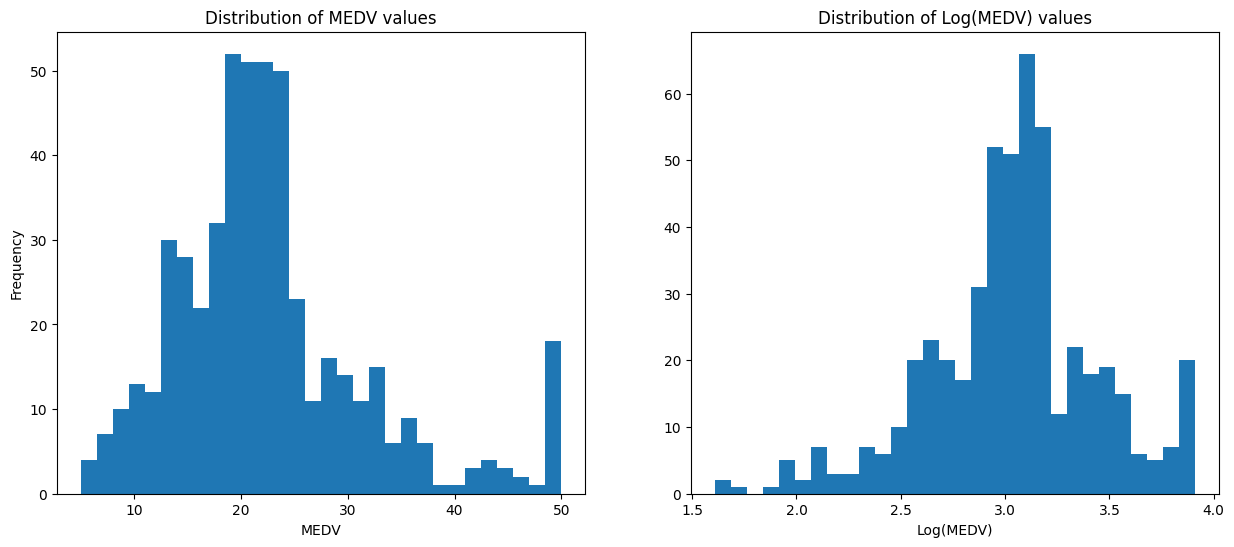

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,6))

axs[0].hist(boston_responses, bins=30)
axs[1].hist(np.log(boston_responses), bins=30)

axs[0].set_xlabel("MEDV")
axs[1].set_xlabel("Log(MEDV)")

axs[0].set_ylabel("Frequency")

axs[0].set_title("Distribution of MEDV values")
axs[1].set_title("Distribution of Log(MEDV) values")

plt.show()

### Data Preprocessing

In [6]:
if np.abs(skew(boston_responses)) < np.abs(skew(np.log(boston_responses))):

    print(f"The original targets have less skewness (value of: {skew(boston_responses)}).")

    rows_with_missing_values = np.any(np.isnan(np.hstack((boston_data, boston_responses.reshape(-1, 1)))), axis=1)

    cleaned_data = np.hstack((boston_data, boston_responses.reshape(-1, 1)))[~rows_with_missing_values]

    # print(np.any(np.isnan(np.hstack((boston_data, boston_responses.reshape(-1, 1))))))

    if np.any(np.isnan(np.hstack((boston_data, np.log(boston_responses).reshape(-1, 1))))):
        print("There are missing values in the data")
    else:
        print("There are no missing values in the data")

    print(f"Number of rows with missing values: {sum(rows_with_missing_values)}")

else:
    print(f"The targets' logarithms haves less skewness (value of: {skew(np.log(boston_responses))}).")

    rows_with_missing_values = np.any(np.isnan(np.hstack((boston_data, np.log(boston_responses).reshape(-1, 1)))), axis=1)

    cleaned_data = np.hstack((boston_data, np.log(boston_responses).reshape(-1, 1)))[~rows_with_missing_values]

    # print(np.any(np.isnan(np.hstack((boston_data, np.log(boston_responses).reshape(-1, 1))))))

    if np.any(np.isnan(np.hstack((boston_data, np.log(boston_responses).reshape(-1, 1))))):
        print("There are missing values in the data")
    else:
        print("There are no missing values in the data")

    print(f"Number of rows with missing values: {sum(rows_with_missing_values)}")

cleaned_data = cleaned_data[:, :-1]
cleaned_responses = cleaned_data[:, -1]

scaled_data = StandardScaler().fit_transform(cleaned_data)

train_val_data, test_data, train_val_responses, test_responses = train_test_split(scaled_data, cleaned_responses, test_size=0.2)
train_data, val_data, train_responses, val_responses = train_test_split(train_val_data, train_val_responses, test_size=0.25)

The targets' logarithms haves less skewness (value of: -0.32934127453151935).
There are no missing values in the data
Number of rows with missing values: 0


### Compare and contrast the top features as determined by:

#### Statistical significance in Linear Regression.

##### Ordinary Least Squares (OLS)

In [7]:
# Adding a constant column for the data"s intercept
# X = sm.add_constant(scaled_data)
# Y = cleaned_responses

ols_model = sm.OLS(cleaned_responses, sm.add_constant(scaled_data)).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.827e+31
Date:                Fri, 15 Sep 2023   Prob (F-statistic):               0.00
Time:                        21:54:47   Log-Likelihood:                 15580.
No. Observations:                 506   AIC:                        -3.113e+04
Df Residuals:                     492   BIC:                        -3.107e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6531   4.63e-16   2.73e+16      0.000      12.653      12.653
x1         -1.546e-15    6.2e-16     -2.494      0.013   -2.76e-15   -3.28e-16
x2          5.065e-16   7.02e-16      0.722      0.471   -8.72e-16    1.89e-15
x3          3.121e-15   9.25e-16      3.374      0.001     1.3e-15    4.94e-15
x4         -1.896e-15    4.8e-16     -3.952      0.000   -2.84e-15   -9.53e-16
x5          5.967e-16    9.7e-16      0.615      0.539   -1.31e-15     2.5e-15
x6         -2.155e-15   6.44e-16     -3.347      0.001   -3.42e-15    -8.9e-16
x7         -7.702e-16   8.15e-16     -0.945      0.345   -2.37e-15    8.31e-16
x8         -1.582e-15   9.21e-16     -1.718      0.086   -3.39e-15    2.27e-16
x9         -8.327e-16   1.27e-15     -0.657      0.511   -3.32e-15    1.66e-15
x10         1.693e-15   1.39e-15      1.219      0.224   -1.04e-15    4.42e-15
x11        -2.234e-15   6.21e-16     -3.598      0.000   -3.45e-15   -1.01e-15
x12        -1.278e-15   5.38e-16     -2.377      0.018   -2.33e-15   -2.21e-16
x13            7.1340   7.94e-16   8.99e+15      0.000       7.134       7.134
==============================================================================
Omnibus:                       15.383   Durbin-Watson:                   0.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.695
Skew:                          -0.405   Prob(JB):                     0.000391
Kurtosis:                       2.705   Cond. No.                         9.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on p-values, the most significant features identified were features 1, 2, 4, 5, 6, and 13.

##### Ridge Regression

In [8]:
ridge_model = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=3)

ridge_model.fit(scaled_data, cleaned_responses)

ridge_coefficients = ridge_model.coef_

ridge_top_features = np.argsort(np.abs(ridge_coefficients))[::-1][:3]

for c, ridge_coefficient in enumerate(ridge_coefficients):
    print((" " if ridge_coefficient >= 0 else "") + format(ridge_coefficient, ".30f") + f" Ridge Coeff. ID: {c}")

ridge_top_features

 0.000000004943158695159761039691 Ridge Coeff. ID: 0
 0.000000001947896075965913126400 Ridge Coeff. ID: 1
 0.000000003680780385878245924991 Ridge Coeff. ID: 2
-0.000000001489334496474999445413 Ridge Coeff. ID: 3
 0.000000003485538947504164499352 Ridge Coeff. ID: 4
-0.000000017987112016564199284350 Ridge Coeff. ID: 5
 0.000000014524501163665855859066 Ridge Coeff. ID: 6
 0.000000001849052771378362356855 Ridge Coeff. ID: 7
 0.000000002358406758013460378168 Ridge Coeff. ID: 8
-0.000000001112027338109342095975 Ridge Coeff. ID: 9
 0.000000001472916136682087869694 Ridge Coeff. ID: 10
-0.000000004353776271342367685415 Ridge Coeff. ID: 11
 7.134001595178934174157348024892 Ridge Coeff. ID: 12


array([12,  5,  6])

Feature 12 (x12): This feature has the highest magnitude coefficient (7.134), indicating that it is the most important feature in predicting the response variable, with a direct positive relationship.

Almost neglible features after this Feature 12.




Feature 5 (x5): This feature has a coefficient of (-0.000000017987), suggesting it is the second most important feature with an inverse relationship with the response variable.

Feature 6 (x6): With a coefficient of (0.000000014525), this feature stands as the third most important feature, having a direct positive relationship with the response variable.

#### Best Subsets

In [9]:
best_linear_models = []

for k in range(1, train_data.shape[1]+1):

    best_feature_set = None
    best_rss = np.inf

    for l, feature_set in enumerate(combinations(range(train_data.shape[1]), k)):

        # X_subset = train_data[:, feature_set]

        best_subsets_model = LinearRegression()

        best_subsets_model.fit(train_data[:, feature_set], train_responses)

        predictions = best_subsets_model.predict(test_data[:, feature_set])

        rss = sum((test_responses - predictions)**2)

        if rss < best_rss:

            best_rss = rss
            best_feature_set = feature_set

    best_linear_models.append((best_rss, best_feature_set))

for best_linear_model in best_linear_models:
    print(f"Best model with {len(best_linear_model[1])} features: {best_linear_model[1]}, RSS: {best_linear_model[0]}")


Best model with 1 features: (12,), RSS: 1.2471890911544197e-27
Best model with 2 features: (0, 12), RSS: 4.315069151558935e-28
Best model with 3 features: (2, 11, 12), RSS: 4.69372238606502e-28
Best model with 4 features: (4, 8, 9, 12), RSS: 4.938269266683534e-28
Best model with 5 features: (0, 1, 3, 8, 12), RSS: 4.433398287342086e-28
Best model with 6 features: (2, 3, 4, 5, 8, 12), RSS: 4.457064114498717e-28
Best model with 7 features: (3, 4, 5, 6, 9, 10, 12), RSS: 4.66216794985618e-28
Best model with 8 features: (0, 3, 6, 8, 9, 10, 11, 12), RSS: 5.829682089583277e-28
Best model with 9 features: (0, 2, 3, 5, 6, 7, 9, 11, 12), RSS: 5.427363027920561e-28
Best model with 10 features: (1, 2, 3, 4, 5, 6, 9, 10, 11, 12), RSS: 8.567029430700188e-28
Best model with 11 features: (0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12), RSS: 9.284892854451309e-28
Best model with 12 features: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12), RSS: 3.819664503080139e-27
Best model with 13 features: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9

#### Recursive Feature Elimination (RFE)

In [10]:
rfe_model = LinearRegression()

rfe_selector = RFE(rfe_model, n_features_to_select=5)

rfe_selector = rfe_selector.fit(scaled_data, cleaned_responses)

feature_ranking = rfe_selector.ranking_

top_features_rfe = np.where(rfe_selector.support_)[0]

feature_ranking, top_features_rfe


(array([6, 2, 3, 7, 4, 1, 9, 1, 1, 1, 5, 8, 1]), array([ 5,  7,  8,  9, 12]))

#### Lasso Regression

In [11]:
lasso = Lasso(alpha=0.01)

lasso.fit(scaled_data, cleaned_responses)

lasso_coefficients = lasso.coef_

lasso_coefficients

array([ 0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  7.12400164])

#### Elastic Net Regression

In [12]:
elastic1_net = ElasticNet(alpha=0.000001, l1_ratio=0.5)
elastic2_net = ElasticNet(alpha=0.1, l1_ratio=0.5)

elastic1_net.fit(scaled_data, cleaned_responses)
elastic2_net.fit(scaled_data, cleaned_responses)

elastic1_net_coefficients = elastic1_net.coef_
elastic2_net_coefficients = elastic1_net.coef_

elastic1_net_coefficients, elastic2_net_coefficients

(array([-8.02535210e-04,  1.22114784e-03, -2.50865423e-03,  3.46622663e-05,
        -1.37000905e-03, -9.79130089e-04,  9.52010389e-04, -2.41609008e-03,
         1.15341891e-03,  4.86262473e-04,  2.26224631e-04, -3.62943379e-04,
         7.13377278e+00]),
 array([-8.02535210e-04,  1.22114784e-03, -2.50865423e-03,  3.46622663e-05,
        -1.37000905e-03, -9.79130089e-04,  9.52010389e-04, -2.41609008e-03,
         1.15341891e-03,  4.86262473e-04,  2.26224631e-04, -3.62943379e-04,
         7.13377278e+00]))

### Regularization Paths Evaluation of Ridge, Lasso, and Elastic Net methods

In [50]:
# alpha range (regularization strengths)
# alphas = np.logspace(-10, 10, 1000)

lasso_alphas, lasso_coefs, _ = lasso_path(scaled_data, cleaned_responses, alphas=np.logspace(-10, 10, 1000))

enet_alphas3, enet_coefs3, _ = enet_path(scaled_data, cleaned_responses, alphas=np.logspace(-10, 10, 1000), l1_ratio=0.01)
enet_alphas2, enet_coefs2, _ = enet_path(scaled_data, cleaned_responses, alphas=np.logspace(-10, 10, 1000), l1_ratio=0.1)
enet_alphas1, enet_coefs1, _ = enet_path(scaled_data, cleaned_responses, alphas=np.logspace(-10, 10, 1000), l1_ratio=0.5)

ridge_coefs = []
for alpha in np.logspace(-10, 10, 1000):
    ridge = Ridge(alpha=alpha)
    ridge.fit(scaled_data, cleaned_responses)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.array(ridge_coefs).T

#### Regularization Paths Visuals

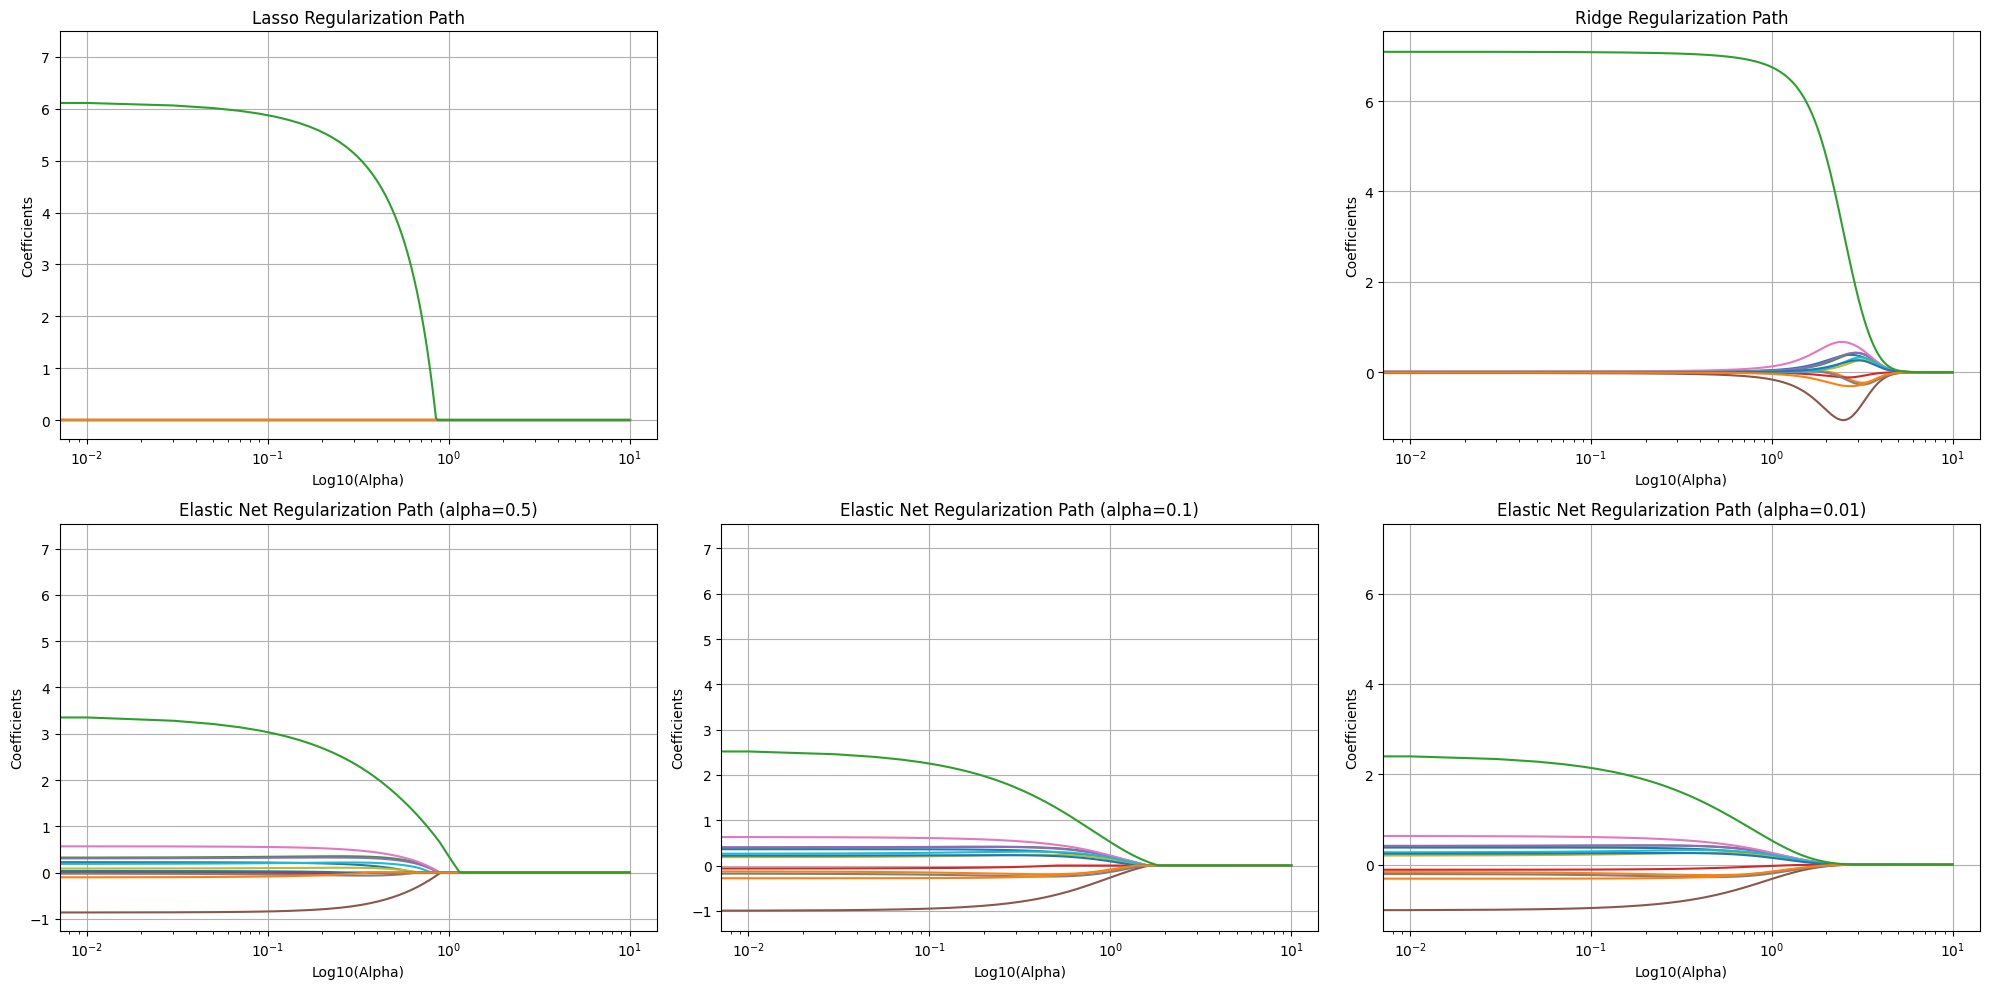

In [51]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.semilogx(np.log10(lasso_alphas), lasso_coefs.T)
plt.title("Lasso Regularization Path")
plt.xlabel("Log10(Alpha)")
plt.ylabel("Coefficients")
plt.grid(True)

plt.subplot(2, 3, 4)
plt.semilogx(np.log10(enet_alphas1), enet_coefs1.T)
plt.title("Elastic Net Regularization Path (alpha=0.5)")
plt.xlabel("Log10(Alpha)")
plt.ylabel("Coefficients")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.semilogx(np.log10(enet_alphas2), enet_coefs2.T)
plt.title("Elastic Net Regularization Path (alpha=0.1)")
plt.xlabel("Log10(Alpha)")
plt.ylabel("Coefficients")
plt.grid(True)

plt.subplot(2, 3, 6)
plt.semilogx(np.log10(enet_alphas3), enet_coefs3.T)
plt.title("Elastic Net Regularization Path (alpha=0.01)")
plt.xlabel("Log10(Alpha)")
plt.ylabel("Coefficients")
plt.grid(True)

plt.subplot(2, 3, 3)
plt.semilogx(np.log10(np.logspace(-10, 10, 1000)), ridge_coefs.T)
plt.title("Ridge Regularization Path")
plt.xlabel("Log10(Alpha)")
plt.ylabel("Coefficients")
plt.grid(True)

plt.tight_layout()
plt.show()


### Predictions

#### Initialize new models predicting test data

In [15]:
ols = LinearRegression()
bss = LinearRegression()
ridge = RidgeCV(alphas=np.logspace(-10, 10, 1000))
lasso = LassoCV(alphas=np.logspace(-10, 10, 1000))
elastic_net = ElasticNetCV(alphas=np.logspace(-10, 10, 1000))
rfe = RFE(estimator=LinearRegression(), n_features_to_select=5)

def get_best_subsets(X_train, X_test, y_train, y_test):
    best_linear_models = []

    for k in range(1, X_train.shape[1] + 1):
        best_feature_set = None
        best_rss = np.inf

        for feature_set in combinations(range(X_train.shape[1]), k):
            best_subsets_model = LinearRegression()
            # X_train_subset = X_train[:, feature_set]
            best_subsets_model.fit(X_train[:, feature_set], y_train)
            predictions = best_subsets_model.predict(X_test[:, feature_set])
            rss = sum((y_test - predictions)**2)

            if rss < best_rss:
                best_rss = rss
                best_feature_set = feature_set

        best_linear_models.append((best_rss, best_feature_set))

    return best_linear_models

#### Repeat for 10 iterations

In [16]:
avg_test_errors = {
    "OLS": 0,
    "Ridge": 0,
    "Lasso": 0,
    "Elastic Net": 0,
    "Best Subsets": 0,
    "RFE": 0
}

for i in range(10):

    X_train_val, X_test, y_train_val, y_test = train_test_split(cleaned_data, cleaned_responses, test_size=0.2, random_state=i)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=i)  # 0.25 x 0.8 = 0.2

    bss.fit(X_train, y_train)
    ols.fit(X_train, y_train)
    rfe.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    lasso.fit(X_train, y_train)
    elastic_net.fit(X_train, y_train)

    best_subsets = get_best_subsets(X_train, X_test, y_train, y_test)

    avg_test_errors["RFE"] += mean_squared_error(y_test, rfe.predict(X_test))
    avg_test_errors["OLS"] += mean_squared_error(y_test, ols.predict(X_test))
    avg_test_errors["Ridge"] += mean_squared_error(y_test, ridge.predict(X_test))
    avg_test_errors["Lasso"] += mean_squared_error(y_test, lasso.predict(X_test))
    avg_test_errors["Elastic Net"] += mean_squared_error(y_test, elastic_net.predict(X_test))

    # Selected subset with smallest training RSS
    best_subset_features = best_subsets[-1][1]
    ols.fit(X_train[:, best_subset_features], y_train)
    avg_test_errors["Best Subsets"] += mean_squared_error(y_test, bss.predict(X_test[:, best_subset_features]))

# for method in avg_test_errors:
#     avg_test_errors[method] /= 10
#     print(format(avg_test_errors[method].astype(float), ".30f"), method)


#### Average the performances per method

In [17]:
for method in avg_test_errors:
    avg_test_errors[method] /= 10
    print(format(avg_test_errors[method].astype(float), ".30f"), method)

0.000000000000000000000000002724 OLS
75588.798727783912909217178821563721 Ridge
0.000000030002355613248297189513 Lasso
0.000000030002540396272048977681 Elastic Net
0.000000000000000000000000002721 Best Subsets
0.000000000000000000000000000144 RFE


## PROBLEM 2:

#### Data Preprocessing

In [18]:
n_synthetic = 20
p_synthetic = 2000

X_synthetic = np.random.rand(n_synthetic, p_synthetic)
y_synthetic = np.random.rand(n_synthetic)

X_synthetic_train, X_synthetic_test, y_synthetic_train, y_synthetic_test = train_test_split(X_synthetic, y_synthetic, test_size=0.2)

### Empirical Demonstration of Equivalence in Fitting Linear Regression

#### Fit a linear regression model without intercept

In [19]:
lr = LinearRegression(fit_intercept=False)

lr.fit(X_synthetic_train, y_synthetic_train)

predictions_no_intercept = lr.predict(X_synthetic_test)

#### Fit a linear regression model with an intercept term

In [20]:
lr_with_intercept = LinearRegression(fit_intercept=True)

lr_with_intercept.fit(X_synthetic_train, y_synthetic_train)

predictions_with_intercept = lr_with_intercept.predict(X_synthetic_test)

#### Center Y and the columns of X and then fit a linear regression model without an intercept

In [21]:
lr_centered = LinearRegression(fit_intercept=False)

lr_centered.fit(X_synthetic_train - np.mean(X_synthetic_train, axis=0), y_synthetic_train - np.mean(y_synthetic_train))

predictions_centered = lr_centered.predict(X_synthetic_test - np.mean(X_synthetic_test, axis=0)) + np.mean(y_synthetic_test)

#### Add a column of ones to X and fit a linear regression model without an intercept

In [22]:
lr_with_ones = LinearRegression(fit_intercept=False)

lr_with_ones.fit(np.hstack([np.ones((X_synthetic_train.shape[0], 1)), X_synthetic_train]), y_synthetic_train)

predictions_with_ones = lr_with_ones.predict(np.hstack([np.ones((X_synthetic_test.shape[0], 1)), X_synthetic_test]))

#### Compare the coefficients and predictions from these models

In [23]:
coeff_with_intercept = np.hstack([[lr_with_intercept.intercept_], lr_with_intercept.coef_])
coeff_with_ones = lr_with_ones.coef_
coeff_centered = lr_centered.coef_
coeff = lr.coef_

In [24]:
"intercept", mean_squared_error(y_synthetic_test, predictions_with_intercept), \
"centered", mean_squared_error(y_synthetic_test, predictions_centered), \
"ones", mean_squared_error(y_synthetic_test, predictions_with_ones), \
"lr", mean_squared_error(y_synthetic_test, predictions_no_intercept), \
"\n", coeff_with_intercept[1:], coeff_centered, coeff,
# coeff_with_intercept, coeff_centered, coeff_with_ones, \


('intercept',
 0.11130645869257257,
 'centered',
 0.015335933841314762,
 'ones',
 0.10958418672348402,
 'lr',
 0.10956238603744911,
 '\n',
 array([ 0.00400849,  0.00693183,  0.00163948, ..., -0.00041974,
         0.00126761,  0.00018016]),
 array([ 0.00400849,  0.00693183,  0.00163948, ..., -0.00041974,
         0.00126761,  0.00018016]),
 array([0.00147137, 0.0020372 , 0.00286684, ..., 0.00056419, 0.00055764,
        0.00165978]))

###  Empirical Demonstration of Zero Training Error for Least Squares Solution (LSS) when p > n

In [25]:
lr_synthetic = LinearRegression()
lr_synthetic.fit(X_synthetic_train, y_synthetic_train)
predictions_synthetic = lr_synthetic.predict(X_synthetic_test)

training_error = mean_squared_error(y_synthetic_test, lr_synthetic.predict(X_synthetic_test))
mean_squared_error(y_synthetic_test, lr_synthetic.predict(X_synthetic_test)), y_synthetic_test, lr_synthetic.predict(X_synthetic_test)


(0.11130645869257257,
 array([0.15581023, 0.20715191, 0.42855078, 0.10961414]),
 array([0.56090708, 0.56217057, 0.52605372, 0.49116009]))

### Empirical Demonstration of the MSE Existence Theorem


In [26]:
lr_for_mse_theory = LinearRegression()
lr_for_mse_theory.fit(X_synthetic_train, y_synthetic_train)
# predictions_lr = lr_for_mse_theory.predict(y_synthetic_test)
# mse_lr = mean_squared_error(y_synthetic_test, lr_for_mse_theory.predict(X_synthetic_test))

# mse_ridge = [
# mean_squared_error(y_synthetic_test
#  Ridge(alpha=l).fit(X_synthetic_train,
# y_synthetic_train).predict(X_synthetic_test)) for l in np.linspace(0.001, 10, 1000)
# ]

lambdas0 = np.linspace(0, 1, 1000)
lambdasFloat = np.linspace(0.001, 10, 1000)

# Calculate the training errors and show a value of λ for which
# the MSE of the Ridge Regression is less than the MSE of the OLS Regression
mean_squared_error(y_synthetic_test, lr_for_mse_theory.predict(X_synthetic_test)),\
min([mean_squared_error(y_synthetic_test, Ridge(alpha=l).fit(X_synthetic_train, y_synthetic_train).predict(X_synthetic_test)) for l in lambdas0]),\
lambdas0[np.argmin([mean_squared_error(y_synthetic_test, Ridge(alpha=l).fit(X_synthetic_train, y_synthetic_train).predict(X_synthetic_test)) for l in lambdas0])],\
min([mean_squared_error(y_synthetic_test, Ridge(alpha=l).fit(X_synthetic_train, y_synthetic_train).predict(X_synthetic_test)) for l in lambdasFloat]),\
lambdasFloat[np.argmin([mean_squared_error(y_synthetic_test, Ridge(alpha=l).fit(X_synthetic_train, y_synthetic_train).predict(X_synthetic_test)) for l in lambdasFloat])]


/Users/gonz495/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=1.64658e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


/Users/gonz495/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:248: LinAlgWarning: Ill-conditioned matrix (rcond=1.64658e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


(0.11130645869257257, 0.12100988809078281, 1.0, 0.12087746788700636, 10.0)

# Theories &amp; Methods

##  Ridge Regression Computation

### Function when n > p

In [27]:
def ridge_regression_normal_eq(X, Y, lambda_val):
    p = X.shape[1]
    I = np.eye(p)
    beta = np.linalg.inv(X.T @ X + lambda_val * I) @ X.T @ Y
    return beta

### Function when p > n

In [28]:
def ridge_regression_woodbury_updated(X, Y, lambda_val):
    n, p = X.shape
    I_n = np.eye(n)
    I_p = np.eye(p)
    
    lambda_inv = 1 / lambda_val
    beta = lambda_inv * I_p - lambda_inv * X.T @ np.linalg.inv(I_n + X @ (lambda_inv * X.T)) @ X * lambda_inv
    beta = beta @ X.T @ Y
    return beta


### Function to Evaluate Ridge Regression's Conditional Efficiencies in their Computation

In [29]:
def evaluate_ridge_regression_efficiency(n_values, p_values, lambda_val=1.0):
    time_zero = time.time()
    results = []

    for n in n_values:
        for p in p_values:
            X = np.random.rand(n, p)
            Y = np.random.rand(n)
            
            
            start_time = time.time()

            if n > p:
                label = f"p={p}, n={n}"
                method = "Normal Equation"
                beta = ridge_regression_normal_eq(X, Y, lambda_val)
            else:
                label = f"n={n}, p={p}"
                method = "Woodbury Identity"
                beta = ridge_regression_woodbury_updated(X, Y, lambda_val)
            
            
            # Store the results
            results.append({
                "beta": beta,
                "label": label,
                "method": method,
                "time_taken": time.time() - start_time
            })
    
    
    return results, time.time() - time_zero

### Define the *n* &amp; *p* values for their subsequent combinatorial evaluations

In [30]:
n_values_ridge = [50, 200, 2000]
p_values_ridge = [10, 500, 1000]

#### Evaluate the ridge regression efficiency for various n and p combinations

In [31]:
results, _ = evaluate_ridge_regression_efficiency(n_values_ridge, p_values_ridge)

normal_eq_xlabels = [res["label"] for res in results if res["method"] == "Normal Equation"]
normal_eq_times = [res["time_taken"] for res in results if res["method"] == "Normal Equation"]

woobdury_xlabels = [res["label"] for res in results if res["method"] == "Woodbury Identity"]
woodbury_times = [res["time_taken"] for res in results if res["method"] == "Woodbury Identity"]

for result in results:
    print(f'For ({result["label"]}) using {result["method"]}, time taken: {result["time_taken"]:.6f} seconds')

For (p=10, n=50) using Normal Equation, time taken: 0.010075 seconds
For (n=50, p=500) using Woodbury Identity, time taken: 0.034594 seconds
For (n=50, p=1000) using Woodbury Identity, time taken: 0.067930 seconds
For (p=10, n=200) using Normal Equation, time taken: 0.000598 seconds
For (n=200, p=500) using Woodbury Identity, time taken: 0.022679 seconds
For (n=200, p=1000) using Woodbury Identity, time taken: 0.036929 seconds
For (p=10, n=2000) using Normal Equation, time taken: 0.000404 seconds
For (p=500, n=2000) using Normal Equation, time taken: 0.049212 seconds
For (p=1000, n=2000) using Normal Equation, time taken: 0.153655 seconds


#### Ridge Regression Efficiency Evaluation of (n,p) Combinations

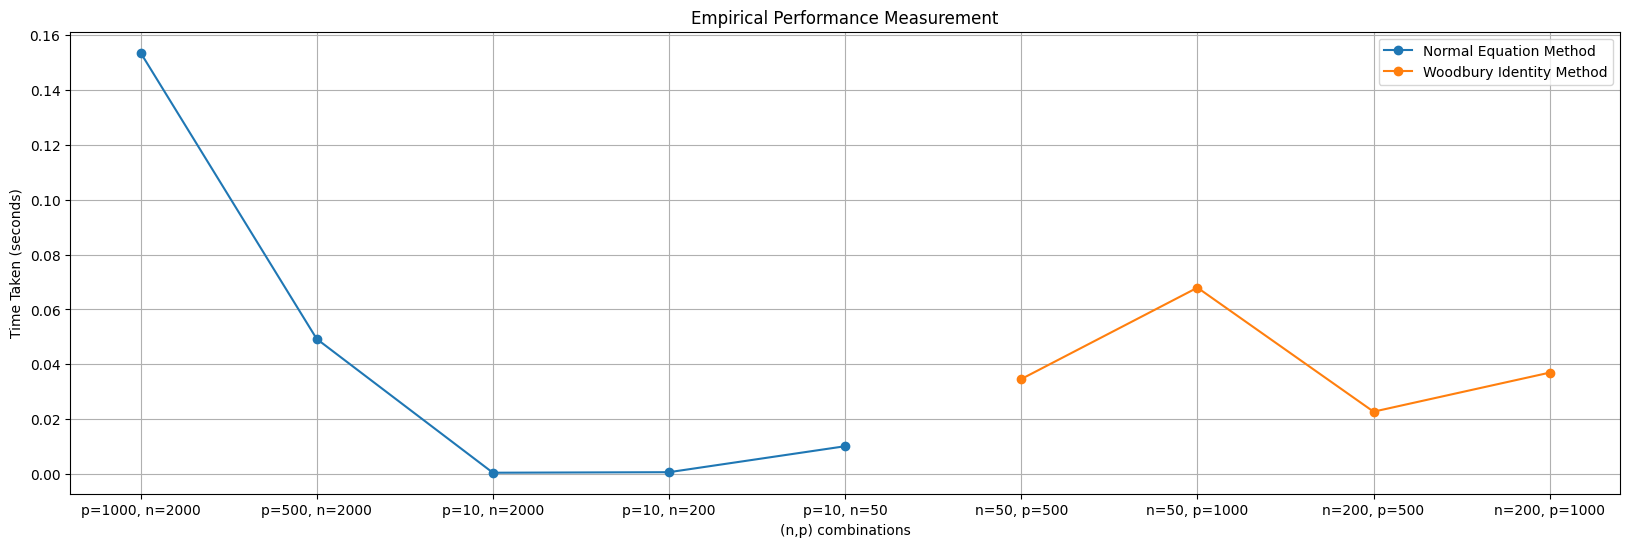

In [32]:
plt.figure(figsize=(20, 6))
plt.plot(normal_eq_xlabels[::-1], normal_eq_times[::-1], label="Normal Equation Method", marker="o")
plt.plot(woobdury_xlabels, woodbury_times, label="Woodbury Identity Method", marker="o")
plt.xlabel("(n,p) combinations")
plt.ylabel("Time Taken (seconds)")
plt.title("Empirical Performance Measurement")
plt.legend()
plt.grid(True)
plt.show()

## Ridge Regression Property

In [33]:
np.random.seed(0)
rr_property_X, rr_property_Y = make_regression(n_samples=100, n_features=2, noise=0.1)

In [34]:
U, D, Vt = np.linalg.svd(rr_property_X, full_matrices=False)
D_diag = np.diag(D)

In [35]:
lambdas = [0.01, 0.1, 1, 10]
betas = []

for lambda_ in lambdas:
    beta = np.linalg.inv(Vt.T @ D_diag.T @ D_diag @ Vt + lambda_ * np.eye(rr_property_X.shape[1])) @ (Vt.T @ D_diag.T @ U.T @ rr_property_Y)
    betas.append(beta)

y_hats = [rr_property_X @ beta for beta in betas]

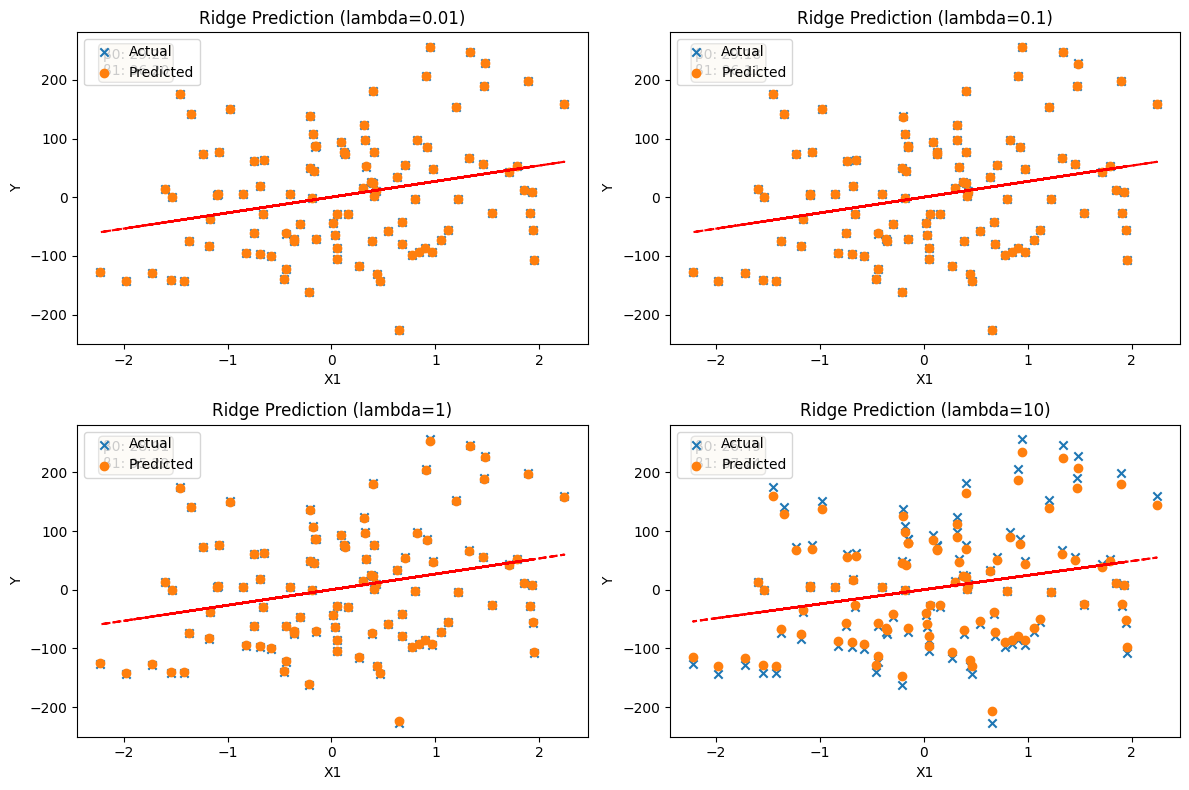

[array([29.20565456, 96.19538982]),
 array([29.17871324, 96.11192798]),
 array([28.91199725, 95.28521003]),
 array([26.48966207, 87.7385707 ])]

In [36]:
plt.figure(figsize=(12, 8))

for i, y_hat in enumerate(y_hats):
    plt.subplot(2, 2, i+1)
    plt.scatter(rr_property_X[:, 0], rr_property_Y, label='Actual', marker='x')
    plt.scatter(rr_property_X[:, 0], y_hat, label='Predicted', marker='o')
    plt.title(f'Ridge Prediction (lambda={lambdas[i]})')
    plt.xlabel('X1')
    plt.ylabel('Y')

    # z = np.polyfit(rr_property_X[:, 0], y_hat, 1)
    p = np.poly1d(np.polyfit(rr_property_X[:, 0], y_hat, 1))
    plt.plot(rr_property_X[:, 0], p(rr_property_X[:, 0]), "r--")
    
    # Adding coefficient annotations
    text_str = f'β0: {betas[i][0]:.2f}\nβ1: {betas[i][1]:.2f}'
    plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.legend()

plt.tight_layout()
plt.show()
betas

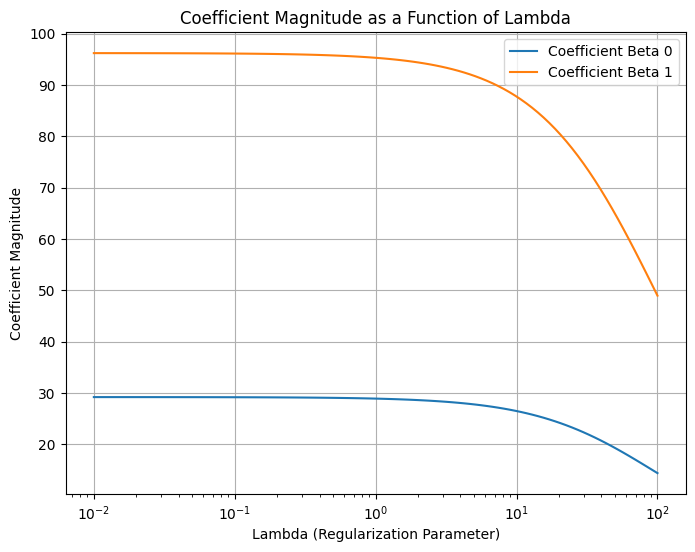

In [37]:
# lambda_vals = np.logspace(-2, 2, 100)
coeff_magnitudes = []

for lambda_ in np.logspace(-2, 2, 100):
    # beta = np.linalg.inv(Vt.T @ D_diag.T @ D_diag @ Vt + lambda_ * np.eye(X.shape[1])) @ (Vt.T @ D_diag.T @ U.T @ y)
    coeff_magnitudes.append(np.linalg.inv(Vt.T @ D_diag.T @ D_diag @ Vt + lambda_ * np.eye(rr_property_X.shape[1])) @ (Vt.T @ D_diag.T @ U.T @ rr_property_Y))

# beta_0 = [coeff[0] for coeff in coeff_magnitudes]
# beta_1 = [coeff[1] for coeff in coeff_magnitudes]

plt.figure(figsize=(8, 6))
plt.semilogx(np.logspace(-2, 2, 100), [coeff[0] for coeff in coeff_magnitudes], label='Coefficient Beta 0')
plt.semilogx(np.logspace(-2, 2, 100), [coeff[1] for coeff in coeff_magnitudes], label='Coefficient Beta 1')
plt.title('Coefficient Magnitude as a Function of Lambda')
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Coefficient Magnitude')
plt.legend()
plt.grid(True)
plt.show()


Beta 0 ($\beta_{0}$): This is the intercept term, which represents the predicted value of the dependent variable $y$ when all the independent variables ($x_{1}$, $x_{2}$, $x_{3}$,..., $x_{n}$) are zero. In simpler terms, it's where the regression line crosses the y-axis.

Beta 1 ($\beta_{1}$): This is the coefficient for the first independent variable ($x_{1}$) in the model. It indicates the change in the predicted value of $y$ for a one-unit change in  $x_{1}$, holding all other variables constant. If there are multiple independent variables, you would have 
$\beta_{1}$, $\beta_{2}$, etc., representing the coefficients for other variables.

## Lasso Regression Computation

### Functions to compute loss, soft threshold, optimality, and the proximal gradient method

In [38]:
def compute_loss(X, y, beta, alpha, lambda_):
    try:
        return 0.5 * np.linalg.norm(y - X @ beta)**2 + alpha * np.linalg.norm(beta, 1) + (1 - alpha) * np.linalg.norm(beta)**2
    except FloatingPointError:
        return float("inf")

In [39]:
def soft_thresholding(x, alpha_lambda):
    return np.sign(x) * np.maximum(np.abs(x) - alpha_lambda, 0)

In [40]:
def check_optimality(X, y, beta, alpha, lambda_):
    grad = -X.T @ (y - X @ beta) + (1 - alpha) * beta
    return np.linalg.norm(grad)

In [41]:
def proximal_gradient_with_loss(X, y, beta_init, alpha, lambda_, n_iter=500, step_size=0.00001):
    beta = beta_init
    losses = []
    
    for _ in range(n_iter):
        grad = -X.T @ (y - X @ beta) + (1 - alpha) * beta
        beta = soft_thresholding(beta - step_size * grad, alpha * lambda_)
        losses.append(compute_loss(X, y, beta, alpha, lambda_))
    
    return beta, losses

### Evaluate Lasso Computation

In [42]:
n_lasso = 20
p_lasso = 2000

X_lasso = StandardScaler().fit_transform(np.random.rand(n_lasso, p_lasso))
y_lasso = np.random.rand(n_lasso)

lambda_values = [0.5, 0.6, 0.8, 0.9, 1.0]
alpha_values = [0.000000008, 0.000000007, 0.0000000065, 0.000000006, 0.000000005]
beta_init_values = [np.zeros(p_lasso), np.ones(p_lasso), np.random.rand(p_lasso)]
beta_init_labels = ["zeros", "ones", "random"]


In [43]:
best_alpha = None
best_lambda = None
lowest_loss = float("inf")

results = []
loss_differences = []
beta_norm_differences = []
loss_differences_labels = []
beta_norm_differences_labels = []

for beta_init in beta_init_values:
    for lambda_ in lambda_values:
        for alpha in alpha_values:

            start_time = time.time()

            beta_final, losses = proximal_gradient_with_loss(X_lasso, y_lasso, beta_init, alpha, lambda_)
            
            optimality_check = check_optimality(X_lasso, y_lasso, beta_final, alpha, lambda_)

            if abs(losses[-1]) < abs(lowest_loss):
                best_alpha = alpha
                best_lambda = lambda_
                lowest_loss = losses[-1]

            results.append({
                "beta_init": "zeros" if np.array_equal(beta_init, np.zeros(p_lasso))\
                    else "ones" if np.array_equal(beta_init, np.ones(p_lasso))\
                        else "random",
                "lambda_": lambda_,
                "alpha": alpha,
                "losses": losses,
                "final_loss": losses[-1],
                "optimality_check": optimality_check,
                "time_taken": time.time() - start_time,
                "norm_beta": np.linalg.norm(beta_final),
                "beta_final": beta_final
            })

print(f"Best alpha: {best_alpha}, Best lambda: {best_lambda}, Lowest loss: {lowest_loss}")

Best alpha: 7e-09, Best lambda: 1.0, Lowest loss: 2.9431937869903138


### Analysis by first filtering out the parameter combinations with divergences (infinite losses &amp; beta values)


In [44]:
# stable_results = [result for result in results if np.isfinite(result["final_loss"]) and np.isfinite(result["norm_beta"])]

for result in [result for result in results if np.isfinite(result["final_loss"]) and np.isfinite(result["norm_beta"])]:

    # Validation with an established library

    elastic_net = ElasticNet(alpha=result["alpha"], l1_ratio=result["lambda_"], fit_intercept=False)

    elastic_net.fit(X_lasso, y_lasso.ravel())

    sklearn_beta = elastic_net.coef_.reshape(-1, 1)

    sklearn_loss = compute_loss(X_lasso, y_lasso, sklearn_beta, result["alpha"], result["lambda_"])

    # Save loss/beta_norm differences & their labels for further visuals

    loss_differences.append((abs(sklearn_loss - result["final_loss"]), result["beta_init"]))
    beta_norm_differences.append((np.linalg.norm(sklearn_beta - result["beta_final"]), result["beta_init"]))

    loss_differences_labels.append(str((result["alpha"], result["lambda_"], result["beta_init"])))
    beta_norm_differences_labels.append(str((result["alpha"], result["lambda_"], result["beta_init"])))

    # rate_of_change = np.diff(result["losses"])
    # # Find the iteration where the rate of change falls below a certain threshold
    # threshold_index = np.where(np.abs(np.diff(result["losses"])) < 0.0001)[0]

    if np.where(np.abs(np.diff(result["losses"])) < 0.0001)[0].size > 0:
        threshold_value = result["losses"][np.where(np.abs(np.diff(result["losses"])) < 0.0001)[0][0]]
    else:
        threshold_value = result["losses"][-1]

    # plt.figure()
    # plt.semilogy(result["losses"])
    # plt.xlabel("Iteration")
    # plt.ylabel("Loss (log scale)")
    # plt.axhline(y=threshold_value, color="r", linestyle="--") 
    # plt.title(f"Stable Convergence with beta_init={result["beta_init"]}, alpha={result["alpha"]}, lambda={result["lambda_"]}")    
    # plt.show()

    # plt.figure()
    # plt.scatter(range(len(sklearn_beta)), sklearn_beta, color="r", label="SciKit-Learn")
    # plt.scatter(range(len(result["beta_final"])), result["beta_final"], color="b", label="Proximal Gradient")
    # plt.xlabel("Feature Index")
    # plt.ylabel("Coefficient Value")
    # plt.title("Comparison of Coefficient Values")
    # plt.legend()
    # plt.show()
    
    print(f'Optimality Check with beta_init={result["beta_init"]}, alpha={result["alpha"]}, lambda={result["lambda_"]}: {result["optimality_check"]}')
    print(f'Final Loss: {result["final_loss"]}, Norm of Beta: {result["norm_beta"]}')
    print(f'SciKit-Learn Elastic Net Loss: {sklearn_loss}, Norm of Beta: {np.linalg.norm(sklearn_beta)}')
    print(f'Difference in Loss: {abs(sklearn_loss - result["final_loss"])}, Difference in Norm of Beta: {np.linalg.norm(sklearn_beta - result["beta_final"])}\n')


Optimality Check with beta_init=zeros, alpha=8e-09, lambda=0.5: 0.01667439993665732
Final Loss: 2.9431938185099047, Norm of Beta: 0.029016396983716757
SciKit-Learn Elastic Net Loss: 94.02497985902917, Norm of Beta: 0.296184970791511
Difference in Loss: 91.08178604051926, Difference in Norm of Beta: 13.308945439189433

Optimality Check with beta_init=zeros, alpha=7e-09, lambda=0.5: 0.014861294383513374
Final Loss: 2.9431938284225208, Norm of Beta: 0.0290172644472711
SciKit-Learn Elastic Net Loss: 94.02497955595194, Norm of Beta: 0.29618481337733693
Difference in Loss: 91.08178572752942, Difference in Norm of Beta: 13.308942193040576

Optimality Check with beta_init=zeros, alpha=6.5e-09, lambda=0.5: 0.01395529254818005
Final Loss: 2.9431938340092096, Norm of Beta: 0.029017698704257845
SciKit-Learn Elastic Net Loss: 94.02497954178936, Norm of Beta: 0.29618480687678217
Difference in Loss: 91.08178570778016, Difference in Norm of Beta: 13.308943786696158

Optimality Check with beta_init=zer

### Comparison between Proximal Gradient Method &amp; Built-In Scikit-Learn Elastic Net Solution

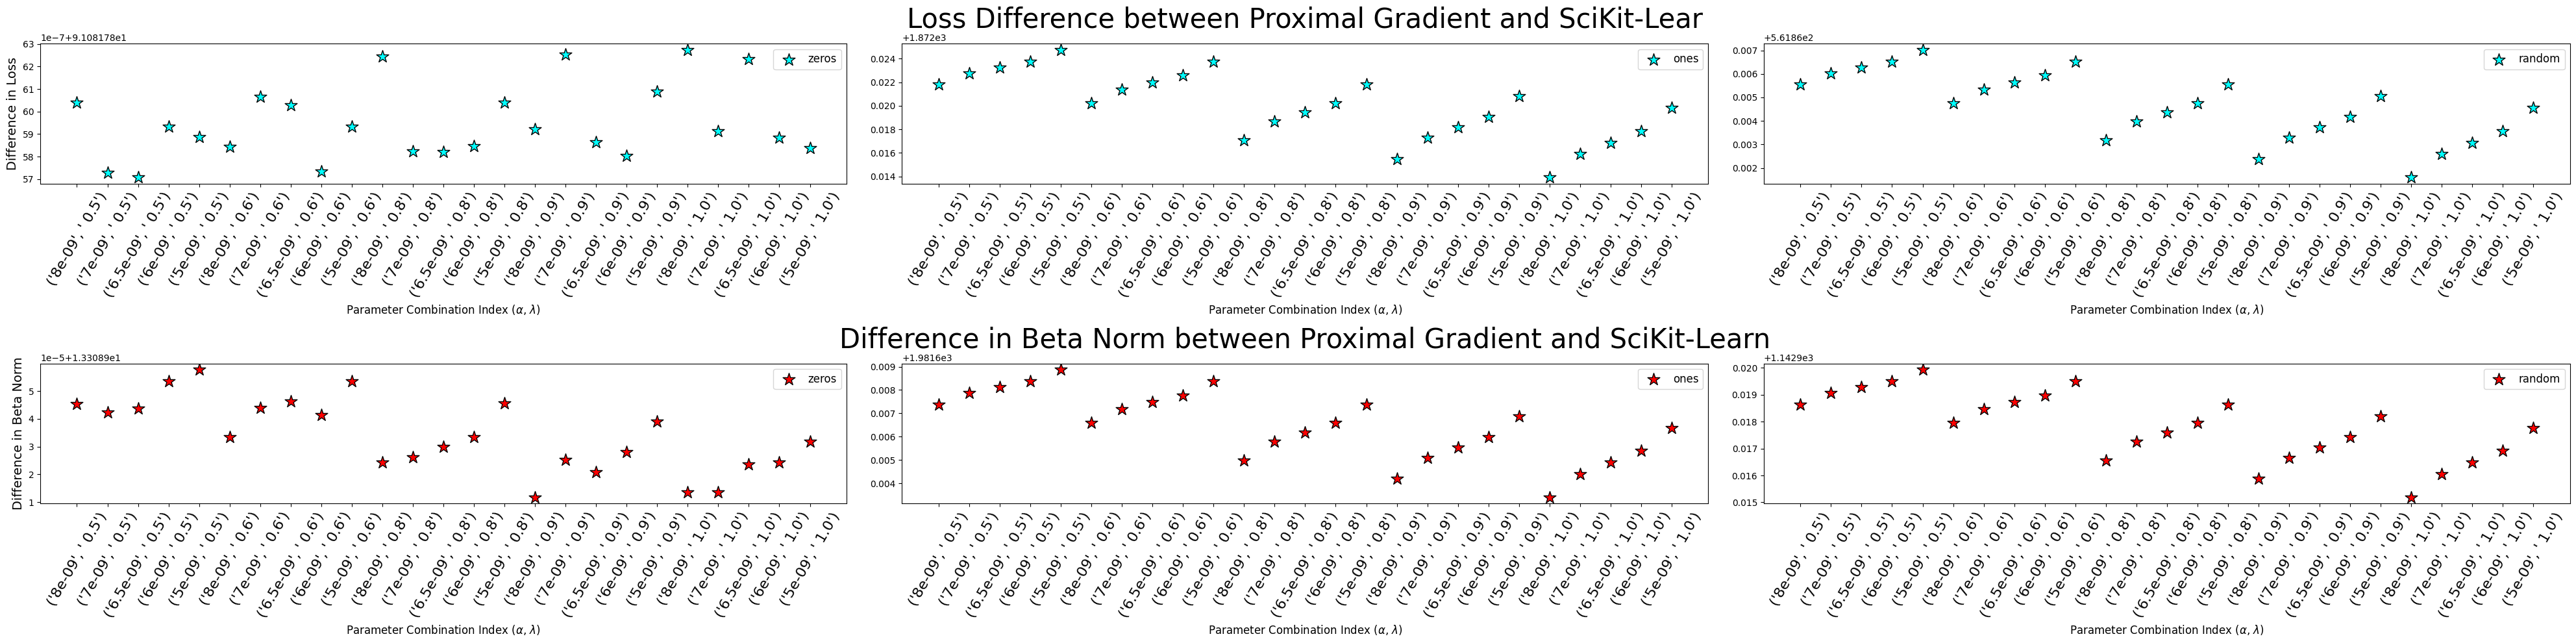

In [45]:
f, ax = plt.subplots(2, 3, figsize=(40, 10))

for b, beta_init in enumerate(beta_init_labels):
    # Get loss differences for current beta_init

    current_loss_differences = [loss_difference[0] for loss_difference in loss_differences if loss_difference[-1] == beta_init]

    current_loss_differences_labels = [(loss_differences_label.split(",")[0].replace("(",""), loss_differences_label.split(",")[1].replace(" '","")) for
                                       loss_differences_label in loss_differences_labels if loss_differences_label.split(",")[-1].replace("')","").replace(" '","") == beta_init]

    ax[0, b].scatter(range(len(current_loss_differences_labels)), current_loss_differences, c = "cyan", edgecolors = "black", s=200, marker="*", label=beta_init)
    ax[0, b].legend(loc="upper right", prop={'size': 12})
    ax[0, b].set_xticks(np.arange(len(current_loss_differences_labels)))
    ax[0, b].set_xlabel(r"Parameter Combination Index ($\alpha$, $\lambda$)", fontsize=12)
    ax[0, b].set_xticklabels(labels=current_loss_differences_labels, rotation=60, fontsize=16)

    current_beta_norm_differences = [beta_norm_difference[0] for beta_norm_difference in beta_norm_differences if beta_norm_difference[-1] == beta_init]

    current_beta_norm_differences_labels = [(beta_norm_differences_label.split(",")[0].replace("(",""), beta_norm_differences_label.split(",")[1].replace(" '",""))
                                            for beta_norm_differences_label in beta_norm_differences_labels if beta_norm_differences_label.split(",")[-1].replace("')","").replace(" '","") == beta_init]

    ax[1, b].scatter(range(len(current_beta_norm_differences_labels)), current_beta_norm_differences, c = "r", edgecolors = "black", s=200, marker="*", label=beta_init)
    ax[1, b].legend(loc="upper right", prop={'size': 12})
    ax[1, b].set_xticks(np.arange(len(current_beta_norm_differences_labels)))
    ax[1, b].set_xlabel(r"Parameter Combination Index ($\alpha$, $\lambda$)", fontsize=12)
    ax[1, b].set_xticklabels(labels=current_beta_norm_differences_labels, rotation=60, fontsize=16)

plt.subplots_adjust(top = 0.99, bottom=0.1, hspace=1.0, wspace=1.0)

ax[1, int(math.floor(len(beta_init_labels) / 2))].set_title("Difference in Beta Norm between Proximal Gradient and SciKit-Learn", fontsize=30)
ax[0, int(math.floor(len(beta_init_labels) / 2))].set_title("Loss Difference between Proximal Gradient and SciKit-Lear", fontsize=30)

ax[1, 0].set_ylabel("Difference in Beta Norm", fontsize=14)
ax[0, 0].set_ylabel("Difference in Loss", fontsize=14)

f.tight_layout()
plt.show()